<a href="https://colab.research.google.com/github/saksham20aggarwal/GANS/blob/main/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



In [2]:
class Discriminator(nn.Module):
  def __init__(self,img_channels,features_dim):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
        nn.Conv2d(img_channels,features_dim, 4,2,1),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(features_dim,features_dim*2,4,2,1),
        nn.BatchNorm2d(features_dim*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(features_dim*2,features_dim*4,4,2,1),
        nn.BatchNorm2d(features_dim*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(features_dim*4,features_dim*8,4,2,1),
        nn.BatchNorm2d(features_dim*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(features_dim*8,1,4,2,0),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self,noise_channel,img_channels,features_gen):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(noise_channel,features_gen*16,4,1,0),
        nn.BatchNorm2d(features_gen*16),
        nn.ReLU(),

        nn.ConvTranspose2d(features_gen*16,features_gen*8,4,2,1),
        nn.BatchNorm2d(features_gen*8),
        nn.ReLU(),

        nn.ConvTranspose2d(features_gen*8,features_gen*4,4,2,1),
        nn.BatchNorm2d(features_gen*4),
        nn.ReLU(),

        nn.ConvTranspose2d(features_gen*4,features_gen*2,4,2,1),
        nn.BatchNorm2d(features_gen*2),
        nn.ReLU(),

        nn.ConvTranspose2d(features_gen*2,img_channels,4,2,1),
        nn.Tanh(),
    )    

  def forward(self,x):
    return self.gen(x)




In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
image_size=64
learning_rate=2e-4
batch_size=128
channels_img=1
noise_dim=100
num_epochs=5
features_disc=64
features_gen=64

In [5]:
transforms=transforms.Compose(
    [transforms.Resize(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
    ]
)

In [6]:
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms,
                       download=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
gen=Generator(noise_dim,channels_img,features_gen).to(device)
disc=Discriminator(channels_img,features_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [9]:
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)


In [12]:
for epoch in range(6):
    last_idx=0
    tk = tqdm(dataloader, total=len(dataloader), position=0 , initial = last_idx,leave=True)

    for batch_idx, (real, _) in enumerate(tk):
        real = real.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        last_idx=batch_idx

        tk.set_description(
                 f" Loss D: {loss_disc.item():.4f}, loss G: {loss_gen.item():.4f}"
            )
        
                

In [ ]:
with torch.no_grad():
  fake = gen(fixed_noise)
  # take out (up to) 32 examples
  # img_grid_real = torchvision.utils.make_grid(
  #     real[:32], normalize=True
  # )
  img_grid_fake = torchvision.utils.make_grid(
      fake[:32], normalize=True
  )
  # img_grid_real=img_grid_real.cpu()
  # plt.imshow(img_grid_real.permute(1, 2, 0))

  img_grid_fake=img_grid_fake.cpu()
  plt.imshow(img_grid_fake.permute(1, 2, 0))

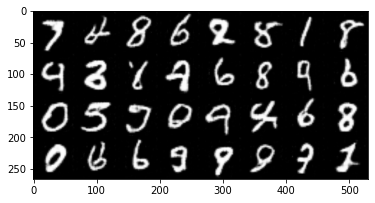

In [ ]:
img_grid_fake=img_grid_fake.cpu()
plt.imshow(img_grid_fake.permute(1, 2, 0))